### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

### Data Preprocessing

In [2]:
# Read the full dataset
df = pd.read_csv("history_weather.csv")

# Remove columns with the same values in all rows
df = df.drop(columns=["snowfall_sum", "sunrise", "sunset"])

# Remove rows where state is Kuala Lumpur or Putrajaya
df = df[~df["state"].isin(["Kuala Lumpur", "Putrajaya"])]

# Rename states
df["state"] = df["state"].replace({"Malacca": "Melaka", "Penang": "Pulau Pinang"})

# Map weather codes
weather_map = {
  0: "Clear",
  1: "Clear",
  2: "Cloudy",
  3: "Cloudy",
  51: "Light Drizzle / Moderate Drizzle",
  53: "Light Drizzle / Moderate Drizzle",
  55: "Heavy Drizzle / Light Rain",
  61: "Heavy Drizzle / Light Rain",
  63: "Moderate Rain / Heavy Rain",
  65: "Moderate Rain / Heavy Rain"
}
df["weather_desc"] = df["weathercode"].map(weather_map)
                            
# Save to CSV
df.to_csv("history_weather_cleaned.csv", index=False)

### Load Data

In [3]:
# Load dataset
df_cleaned = pd.read_csv("history_weather_cleaned.csv")

# Convert data type from 'object' to 'datetime'
df_cleaned['date'] = pd.to_datetime(df['date'])

# Extract year and month from the date column
df_cleaned["year"] = df_cleaned["date"].dt.year
df_cleaned["month"] = df_cleaned["date"].dt.month

### Exploratory Data Analysis

#### Average Temperature per State per Month

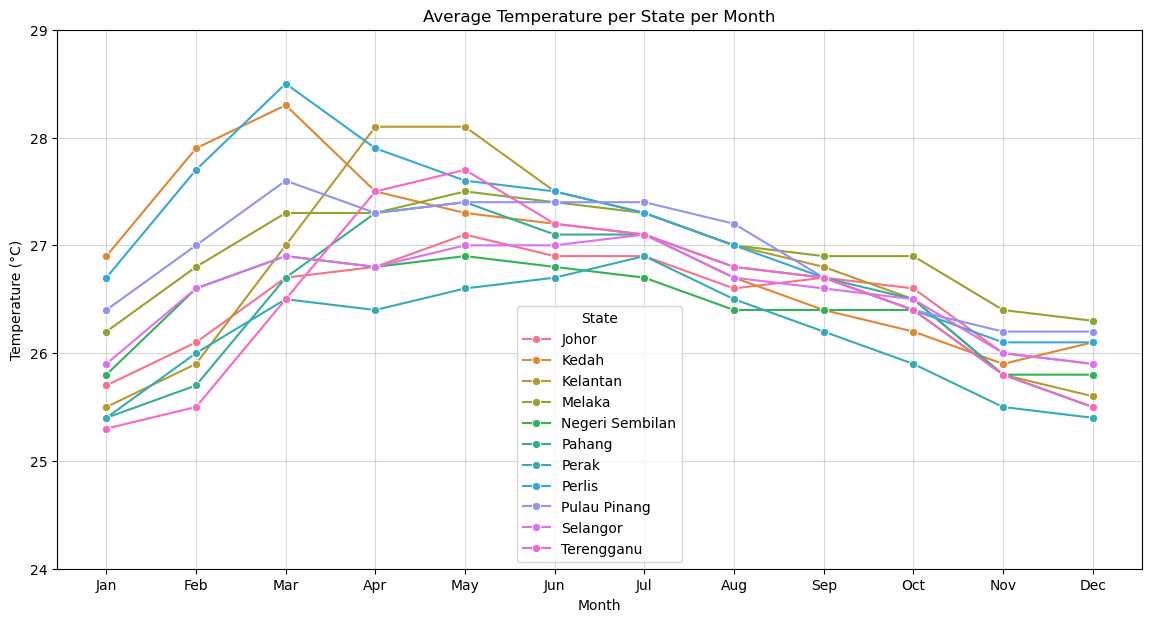

In [4]:
# Compute average temperature per state per month
avg_temp_state_month = df_cleaned.groupby(['state', 'month'])['temperature_2m_mean'].mean().reset_index()
avg_temp_state_month['temperature_2m_mean'] = avg_temp_state_month['temperature_2m_mean'].round(1)


# Plot
plt.figure(figsize=(14,7))
sns.lineplot(
  data=avg_temp_state_month,
  x='month',
  y='temperature_2m_mean',
  hue='state',
  marker='o'
)
plt.title('Average Temperature per State per Month')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')

# x-axis: use month names
months = [calendar.month_abbr[i] for i in range(1,13)]
plt.xticks(ticks=range(1,13), labels=months)

# y-axis: step of 1
y_min = int(avg_temp_state_month['temperature_2m_mean'].min()) - 1
y_max = int(avg_temp_state_month['temperature_2m_mean'].max()) + 1
plt.yticks(range(y_min, y_max+1, 1))

plt.grid(True, alpha=0.5)
plt.legend(title='State')
plt.show()

#### Weather Description Counts

In [5]:
# Count and percentage of each weather description
weather_counts = df['weather_desc'].value_counts()
weather_percent = df['weather_desc'].value_counts(normalize=True) * 100

# Combine into a single DataFrame
weather_summary = pd.DataFrame({
  'Count': weather_counts,
  'Percentage': weather_percent.round(2)
}).reset_index()

# Rename columns for clarity
weather_summary.columns = ['Weather', 'Count', 'Percentage']

# Display the summary
print("====== Weather Summary ======")
print(weather_summary)

====== Weather Summary ======
                            Weather  Count  Percentage
0        Moderate Rain / Heavy Rain  17834       40.35
1  Light Drizzle / Moderate Drizzle  13439       30.41
2        Heavy Drizzle / Light Rain   9541       21.59
3                            Cloudy   3276        7.41
4                             Clear    108        0.24


### Train / Test Split

In [6]:
# Features
features = df_cleaned.drop(columns=["date", "state", "weathercode", "weather_desc", 
                                    "temperature_2m_mean", "temperature_2m_min", "temperature_2m_max",
                                    "apparent_temperature_mean", "apparent_temperature_min", "apparent_temperature_max"])

# Target for temperature prediction (Regression)
y_temp = df_cleaned["temperature_2m_mean"]
# Target for weather prediction (Classification)
y_weather = df_cleaned["weather_desc"]

# Split Train/Test by year
x_train = features[df_cleaned["year"] <= 2022]
x_test  = features[df_cleaned["year"] >= 2023]
y_temp_train = y_temp[df_cleaned["year"] <= 2022]
y_temp_test  = y_temp[df_cleaned["year"] >= 2023]
y_weather_train = y_weather[df_cleaned["year"] <= 2022]
y_weather_test  = y_weather[df_cleaned["year"] >= 2023]

# Print shapes
print("Train Shape:", x_train.shape)
print("Test Shape:", x_test.shape)

Train Shape: (36157, 12)
Test Shape: (8041, 12)


### Model Training and Testing

#### Regression Model

In [7]:
# Train
reg_model = LGBMRegressor(random_state=7, verbose=-1)
reg_model.fit(x_train, y_temp_train)

# Test
y_temp_pred = reg_model.predict(x_test)

# Evaluate
mae = mean_absolute_error(y_temp_test, y_temp_pred)
mape = np.mean(np.abs((y_temp_test - y_temp_pred) / y_temp_test)) * 100

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}°C ")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}% ")

Mean Absolute Error (MAE): 0.48°C 
Mean Absolute Percentage Error (MAPE): 1.76% 


#### Classification Model

In [8]:
# Train
clf_model = LGBMClassifier(random_state=7, class_weight='balanced')
clf_model.fit(x_train, y_weather_train)

# Test
y_weather_pred = clf_model.predict(x_test)

# Evaluate
# Overall accuracy
acc = accuracy_score(y_weather_test, y_weather_pred)
# Per-class accuracy
classes = np.unique(y_weather_test)
per_class_acc = defaultdict(float)
for c in classes:
    idx = (y_weather_test == c)
    per_class_acc[c] = (y_weather_pred[idx] == y_weather_test[idx]).mean() * 100

# Print metrics
print(f"Overall Accuracy: {acc*100:.2f}%")
print("\nPer-class Accuracy:")
for c, a in per_class_acc.items(): 
    print(f"  {c:<10}:  {a:6.2f}%")
print("\nClassification Report:")
print(classification_report(y_weather_test, y_weather_pred, zero_division=0))

Overall Accuracy: 90.10%

Per-class Accuracy:
  Clear     :    0.00%
  Cloudy    :  100.00%
  Heavy Drizzle / Light Rain:   74.36%
  Light Drizzle / Moderate Drizzle:   92.19%
  Moderate Rain / Heavy Rain:   93.08%

Classification Report:
                                  precision    recall  f1-score   support

                           Clear       0.00      0.00      0.00         1
                          Cloudy       1.00      1.00      1.00       428
      Heavy Drizzle / Light Rain       0.69      0.74      0.71      1330
Light Drizzle / Moderate Drizzle       0.94      0.92      0.93      2176
      Moderate Rain / Heavy Rain       0.95      0.93      0.94      4106

                        accuracy                           0.90      8041
                       macro avg       0.71      0.72      0.72      8041
                    weighted avg       0.90      0.90      0.90      8041



#### Classification Model with SMOTE

In [9]:
# Encode labels
le = LabelEncoder()
y_weather_train_enc = le.fit_transform(y_weather_train)
y_weather_test_enc  = le.transform(y_weather_test)

# Apply SMOTE to training data
smote = SMOTE(random_state=7)
x_resampled, y_resampled = smote.fit_resample(x_train, y_weather_train_enc)
# Class distribution before and after SMOTE
print("Class Distribution Before SMOTE:", np.bincount(y_weather_train_enc))
print("Class Distribution After SMOTE :", np.bincount(y_resampled))

# Train
clf_model_smote = LGBMClassifier(random_state=7, class_weight='balanced')
clf_model_smote.fit(x_resampled, y_resampled)

# Test
y_weather_pred = clf_model_smote.predict(x_test)

# Evaluate
# Overall accuracy
acc = accuracy_score(y_weather_test_enc, y_weather_pred)
# Per-class accuracy
classes = le.classes_
per_class_acc = defaultdict(float)
for i, c in enumerate(classes):
    idx = (y_weather_test_enc == i)
    per_class_acc[c] = (y_weather_pred[idx] == y_weather_test_enc[idx]).mean() * 100

# Print metrics
print(f"\nOverall Accuracy: {acc*100:.2f}%")
print("\nPer-class Accuracy:")
for c, a in per_class_acc.items(): 
    print(f"  {c:<10}:  {a:6.2f}%")
print("\nClassification Report:")
print(classification_report(y_weather_test_enc, y_weather_pred, target_names=le.classes_, zero_division=0))

Class Distribution Before SMOTE: [  107  2848  8211 11263 13728]
Class Distribution After SMOTE : [13728 13728 13728 13728 13728]

Overall Accuracy: 90.32%

Per-class Accuracy:
  Clear     :    0.00%
  Cloudy    :  100.00%
  Heavy Drizzle / Light Rain:   67.89%
  Light Drizzle / Moderate Drizzle:   93.29%
  Moderate Rain / Heavy Rain:   95.03%

Classification Report:
                                  precision    recall  f1-score   support

                           Clear       0.00      0.00      0.00         1
                          Cloudy       1.00      1.00      1.00       428
      Heavy Drizzle / Light Rain       0.72      0.68      0.70      1330
Light Drizzle / Moderate Drizzle       0.93      0.93      0.93      2176
      Moderate Rain / Heavy Rain       0.93      0.95      0.94      4106

                        accuracy                           0.90      8041
                       macro avg       0.72      0.71      0.71      8041
                    weighted avg    

### Model Prediction

In [10]:
# Create a dataframe for all state-date combinations
date_range = pd.date_range(start='2025-01-01', end='2026-12-31', freq='D')
states = df_cleaned['state'].unique()
pred_df = pd.DataFrame([
    {'date': date, 'state': state}
    for date in date_range
    for state in states
])

# Extract year and month
pred_df['year'] = pred_df['date'].dt.year
pred_df['month'] = pred_df['date'].dt.month

# Compute historical monthly averages for environmental features by state
state_month_features = df_cleaned.groupby(['state', 'month']).agg({
    'windspeed_10m_max': 'mean',
    'windgusts_10m_max': 'mean',
    'winddirection_10m_dominant': 'mean',
    'shortwave_radiation_sum': 'mean',
    'et0_fao_evapotranspiration': 'mean',
    'daylight_duration': 'mean',
    'sunshine_duration': 'mean',
    'precipitation_sum': 'mean',
    'rain_sum': 'mean',
    'precipitation_hours': 'mean'
}).reset_index()
# Merge into the dataframe
pred_df = pred_df.merge(state_month_features, on=['state', 'month'], how='left')

# Predict temperature 
pred_temp = pred_df[x_train.columns]
pred_df['temperature_2m_mean'] = reg_model.predict(pred_temp).round().astype(int)

# Predict weather description
pred_weather = pred_df[x_train.columns]
pred_df['weather_desc'] = clf_model.predict(pred_weather)

# Save to CSV
preds = pred_df[['date', 'state', 'temperature_2m_mean', 'weather_desc']].copy()
preds = preds.sort_values(['date', 'state']).reset_index(drop=True)
preds.to_csv('weather_predictions.csv', index=False)

# Print prediction summary
print(f"Predicted Temperature Range: {pred_df['temperature_2m_mean'].min()}°C to {pred_df['temperature_2m_mean'].max()}°C")
print(f"\nPredicted Weather Distribution:")
weather_counts = pred_df['weather_desc'].value_counts()
for weather, count in weather_counts.items():
    pct = (count / len(pred_df)) * 100
    print(f"  {weather:<15}: {pct:5.2f}%")

Predicted Temperature Range: 25°C to 29°C

Predicted Weather Distribution:
  Moderate Rain / Heavy Rain: 79.93%
  Heavy Drizzle / Light Rain: 20.07%


### Naive Baseline

#### Temperature Prediction

In [11]:
# Convert temperature array into pandas Series and align with the training features index
y_temp_train_s = pd.Series(y_temp_train, index=x_train.index, name='temperature_2m_mean')

# Prepare training data with state and month
temp_baseline = y_temp_train_s.to_frame().join(x_train[['year', 'month']])
temp_baseline['state'] = df_cleaned.loc[y_temp_train_s.index, 'state']

# Compute monthly mean temperature per state
monthly_mean_temp = temp_baseline.groupby(['state', 'month'])['temperature_2m_mean'].mean().reset_index()

# Prepare test data with state and month
x_test_with_state = x_test.copy()
x_test_with_state['state'] = df_cleaned.loc[x_test.index, 'state']
x_test_with_state['month'] = df_cleaned.loc[x_test.index, 'month']

# Merge to get naive predictions
temp_pred_naive = x_test_with_state.merge(monthly_mean_temp, on=['state', 'month'], how='left')['temperature_2m_mean']

# Evaluate
mae_naive = mean_absolute_error(y_temp_test, temp_pred_naive)
mape_naive = np.mean(np.abs((y_temp_test - temp_pred_naive) / y_temp_test)) * 100

# Print metrics
print(f"Mean Absolute Error (MAE): {mae_naive:.2f}°C ")
print(f"Mean Absolute Percentage Error (MAPE): {mape_naive:.2f}% ")

Mean Absolute Error (MAE): 0.69°C 
Mean Absolute Percentage Error (MAPE): 3.24% 


#### Weather Description Prediction

In [12]:
# Convert weather array into pandas Series and align with the training features index
y_weather_train_s = pd.Series(y_weather_train, index=x_train.index, name='weather_desc')

# Prepare training data with state and month
weather_baseline = y_weather_train_s.to_frame().join(x_train[['year', 'month']])
weather_baseline['state'] = df_cleaned.loc[y_weather_train_s.index, 'state']

# Compute most frequent weather per state and month
most_freq_weather = weather_baseline.groupby(['state', 'month'])['weather_desc'] \
    .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]).reset_index()

# Merge to get naive predictions
weather_pred_naive = x_test_with_state.merge(most_freq_weather, on=['state', 'month'], how='left')['weather_desc']

# Evaluate
# Overall accuracy
acc_naive = accuracy_score(y_weather_test, weather_pred_naive)
# Per-class accuracy
y_true = y_weather_test.reset_index(drop=True)
y_pred = weather_pred_naive.reset_index(drop=True)
classes = np.unique(y_true)
per_class_acc = {c: (y_pred[y_true == c] == c).mean() * 100 for c in classes}

# Print metrics
print(f"Overall Accuracy: {acc_naive*100:.2f}%")
print("\nPer-class Accuracy:")
for c, a in per_class_acc.items(): 
    print(f"  {c:<10}:  {a:6.2f}%")
print("\nClassification Report:")
print(classification_report(y_weather_test, weather_pred_naive, zero_division=0))

Overall Accuracy: 51.78%

Per-class Accuracy:
  Clear     :    0.00%
  Cloudy    :    6.78%
  Heavy Drizzle / Light Rain:    0.60%
  Light Drizzle / Moderate Drizzle:   51.79%
  Moderate Rain / Heavy Rain:   73.06%

Classification Report:
                                  precision    recall  f1-score   support

                           Clear       0.00      0.00      0.00         1
                          Cloudy       0.25      0.07      0.11       428
      Heavy Drizzle / Light Rain       0.13      0.01      0.01      1330
Light Drizzle / Moderate Drizzle       0.39      0.52      0.44      2176
      Moderate Rain / Heavy Rain       0.61      0.73      0.66      4106

                        accuracy                           0.52      8041
                       macro avg       0.28      0.26      0.24      8041
                    weighted avg       0.45      0.52      0.47      8041

